<a href="https://colab.research.google.com/github/EyeofaThous/AAE590/blob/main/HW2work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np

# Specify the path to the .npz file
file_path = '/content/drive/MyDrive/Spatiotemporal Prediction of Microstructure Evolution with Predictive Recurrent Neural Network.zip (Unzipped Files)/train.npz'

# Load the .npz file
data = np.load(file_path)
input_raw = data['input_raw_data']

In [2]:
print("Arrays in the file:", data.files)


Arrays in the file: ['clips', 'dims', 'input_raw_data']


In [4]:
for array_name in data.files:
    array = data[array_name]
    print(f"\nArray Name: {array_name}")
    print(f"Shape: {array.shape}")
    print(f"Data Type: {array.dtype}")
    print(f"Contents:\n{array}\n")


Array Name: clips
Shape: (2, 10000, 2)
Data Type: int32
Contents:
[[[     0     10]
  [    20     10]
  [    40     10]
  ...
  [199940     10]
  [199960     10]
  [199980     10]]

 [[    10     10]
  [    30     10]
  [    50     10]
  ...
  [199950     10]
  [199970     10]
  [199990     10]]]


Array Name: dims
Shape: (1, 3)
Data Type: int32
Contents:
[[ 1 64 64]]


Array Name: input_raw_data
Shape: (200000, 1, 64, 64)
Data Type: int64
Contents:
[[[[0 0 0 ... 1 1 1]
   [0 0 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   ...
   [0 0 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   [1 1 1 ... 0 0 1]]]


 [[[0 0 0 ... 1 1 1]
   [0 0 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   ...
   [0 0 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   [1 1 1 ... 0 0 1]]]


 [[[0 0 0 ... 1 1 1]
   [0 0 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   ...
   [0 0 1 ... 1 1 1]
   [1 1 1 ... 1 1 1]
   [1 1 1 ... 0 0 1]]]


 ...


 [[[0 0 0 ... 1 1 1]
   [0 0 0 ... 0 1 1]
   [0 0 1 ... 0 0 0]
   ...
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0 0 0]
   [0 0 1 ... 0

In [5]:
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# Limit to first 1,000 sequences
num_seq = 1000
subset_raw = input_raw[:num_seq * 20]
time_values = np.array([25000, 28000, 31000, 35000, 37500, 40000, 45000, 50000, 75000, 108000, 180000, 220000, 250000, 270000
                        , 300000, 360000, 430000, 540000, 900000, 1080000])

def comp_grain_size(image):
  _, binary = cv2.threshold((image*255).astype(np.uint8),0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  contours, _= cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  areas = [cv2.contourArea(cnt) for cnt in contours if cv2.contourArea(cnt) > 5]
  return np.mean(areas) if areas else 1e-6

all_grain_size = np.zeros((num_seq, 20))

for seq in range(num_seq):
  seq_images = subset_raw[seq*20:(seq+1)*20,0,:,:]
  grain_size = np.array([comp_grain_size(img) for img in seq_images])

  first_grain_size = max(grain_size[0],1)

  all_grain_size[seq] = grain_size/first_grain_size

x_time_log = np.tile(np.log(time_values),num_seq)
y_grain_sizes = all_grain_size.flatten()

# IQR Removal of Outliers
Q1 = np.percentile(y_grain_sizes,25)
Q3 = np.percentile(y_grain_sizes,75)
IQR = Q3-Q1
l_bound = Q1-1.5*IQR
u_bound = Q3+1.5*IQR

#Outlier filtering
allowed = (y_grain_sizes >= l_bound) & (y_grain_sizes <= u_bound)
x_filt = x_time_log[allowed]
y_filt = y_grain_sizes[allowed]



Lasso & Ridge Regression\


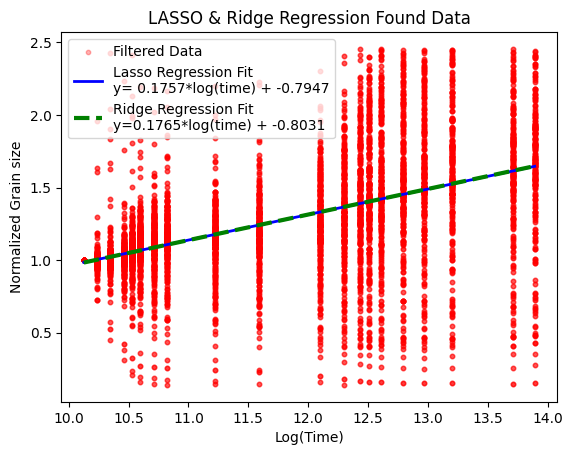

In [13]:
lasso = Lasso(alpha=0.001)
lasso.fit(x_filt.reshape(-1,1),y_filt)

ridge = Ridge(alpha=1)
ridge.fit(x_filt.reshape(-1,1),y_filt)

# Lasso Coefficient calculations
Lslope = lasso.coef_[0]
Linter = lasso.intercept_

# Lasso Regression Equation
Leqn = f"y= {Lslope:.4f}*log(time) + {Linter:.4f}"
# Ridge Coefficient calculations
Rslope = ridge.coef_[0]
Rinter = ridge.intercept_
# Ridge Regression Equation
Reqn = f"y={Rslope:.4f}*log(time) + {Rinter:.4f}"

#Plot & Prediction
Lpred_grain_size = lasso.predict(np.log(time_values).reshape(-1,1))
Rpred_grain_size = ridge.predict(np.log(time_values).reshape(-1,1))
plt.scatter(x_filt,y_filt, label="Filtered Data", color='red',alpha=0.3,s=10)
plt.plot(np.log(time_values), Lpred_grain_size, label=f"Lasso Regression Fit\n{Leqn}", color="blue", linewidth=2)
plt.plot(np.log(time_values),Rpred_grain_size, label=f"Ridge Regression Fit\n{Reqn}",color='green',linewidth=3,linestyle='--')
plt.xlabel("Log(Time)")
plt.title('LASSO & Ridge Regression Found Data')
plt.ylabel("Normalized Grain size")
plt.legend()
plt.show()


Ridge Regression

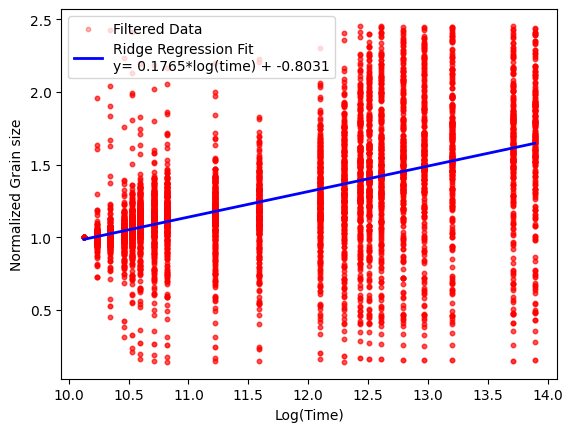

In [24]:


#Coefficient calculations
slope = ridge.coef_[0]
inter = ridge.intercept_

# Regression Equation
eqn = f"y= {slope:.4f}*log(time) + {inter:.4f}"

#Plot & Prediction
pred_grain_size = lasso.predict(np.log(time_values).reshape(-1,1))

plt.scatter(x_filt,y_filt, label="Filtered Data", color='red',alpha=0.3,s=10)
plt.plot(np.log(time_values), pred_grain_size, label=f"Ridge Regression Fit\n{eqn}", color="blue", linewidth=2)
plt.xlabel("Log(Time)")
plt.ylabel("Normalized Grain size")
plt.legend()
plt.show()